In [1]:
import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".99"
import jax
import jax.numpy as jnp
import numpy as np
from functools import partial
from flax import struct
import chex

from typing import Callable

from f1tenth_gym_jax import make
from f1tenth_gym_jax.envs import F110Env
from f1tenth_gym_jax.envs.dynamic_models import vehicle_dynamics_st_switching
from f1tenth_gym_jax.envs.integrator import integrate_rk4
from f1tenth_gym_jax.envs.utils import batchify, unbatchify
from f1tenth_gym_jax.envs.track.cubic_spline import nearest_point_on_trajectory_jax

from f1tenth_gym_jax.envs.rendering.renderer import TrajRenderer

In [2]:
@struct.dataclass
class MPPIConfig:
    # mppi
    n_iterations: int = 1
    n_steps: int = 10
    n_samples: int = 128
    temperature: float = 0.01
    damping: float = 0.001
    dt: float = 0.1

    # system
    control_dim: int = 2  # [steering_velocity, longitudinal_acceleration]
    state_dim: int = 7  # [x, y, delta, v, psi, psi_dot, beta]
    dyn_fn: Callable = vehicle_dynamics_st_switching
    int_fn: Callable = integrate_rk4
    control_limit: chex.Array = struct.field(
        default_factory=lambda: jnp.array([[-3.2, -10.0], [3.2, 10.0]])
    )

In [3]:
@jax.jit
def get_ref_traj(
    predicted_speeds,
    dist_from_segment_start,
    idx,
    waypoints,
    waypoints_distances,
    DT,
):
    total_length = jnp.sum(waypoints_distances)
    s_relative = jnp.concatenate(
        [jnp.array([dist_from_segment_start]), predicted_speeds * DT]
    ).cumsum()
    s_relative = s_relative % total_length
    rolled_distances = jnp.roll(waypoints_distances, -idx)
    wp_dist_cum = jnp.concatenate([jnp.array([0.0]), jnp.cumsum(rolled_distances)])
    index_relative = jnp.searchsorted(wp_dist_cum, s_relative, side="right") - 1
    index_relative = jnp.clip(index_relative, 0, len(rolled_distances) - 1)
    index_absolute = (idx + index_relative) % (waypoints.shape[0] - 1)
    next_index = (index_absolute + 1) % (waypoints.shape[0] - 1)
    seg_start = wp_dist_cum[index_relative]
    seg_len = rolled_distances[index_relative]
    t = (s_relative - seg_start) / seg_len
    p0 = waypoints[index_absolute][:, 1:3]
    p1 = waypoints[next_index][:, 1:3]
    interpolated_positions = p0 + (p1 - p0) * t[:, jnp.newaxis]
    s0 = waypoints[index_absolute][:, 0]
    s1 = waypoints[next_index][:, 0]
    interpolated_s = (s0 + (s1 - s0) * t) % waypoints[-1, 0]
    yaw0 = waypoints[index_absolute][:, 3]
    yaw1 = waypoints[next_index][:, 3]
    interpolated_yaw = yaw0 + (yaw1 - yaw0) * t
    interpolated_yaw = (interpolated_yaw + jnp.pi) % (2 * jnp.pi) - jnp.pi
    v0 = waypoints[index_absolute][:, 4]
    v1 = waypoints[next_index][:, 4]
    interpolated_speed = v0 + (v1 - v0) * t
    reference = jnp.stack(
        [
            interpolated_positions[:, 0],
            interpolated_positions[:, 1],
            interpolated_speed,
            interpolated_yaw,
            interpolated_s,
            jnp.zeros_like(interpolated_speed),
            jnp.zeros_like(interpolated_speed),
        ],
        axis=1,
    )
    return reference

In [4]:
class MPPI:
    def __init__(
        self,
        config: MPPIConfig,
        env: F110Env,
        rng: jax.random.PRNGKey,
    ):
        self.config = config
        self.env = env
        self.rng = rng

        self.n_iterations = config.n_iterations
        self.n_steps = config.n_steps
        self.n_samples = config.n_samples
        self.a_shape = config.control_dim

        self.accum_matrix = jnp.triu(jnp.ones((self.n_steps, self.n_steps)))

        line = self.env.track.raceline
        self.waypoints = jnp.column_stack(
            (line.ks, line.xs, line.ys, line.psis, line.vxs)
        )
        self.waypoint_distances = jnp.linalg.norm(
            self.waypoints[1:, :2] - self.waypoints[:-1, :2], axis=1
        )

    @partial(jax.jit, static_argnums=(0))
    def weights(self, cost):
        # cost: [n_samples, n_steps]
        min_cost = jnp.min(cost, axis=0, keepdims=True)  # [n_samples, n_steps]
        max_cost = jnp.max(cost, axis=0, keepdims=True)  # [n_samples, n_steps]
        cost = (cost - min_cost) / (max_cost - min_cost + self.config.damping)  # [n_samples, n_steps]

        w = jnp.exp(-cost / self.config.temperature)  # [n_samples, n_steps]
        # w = w / (jnp.sum(w, axis=0) + self.config.damping)  # [n_samples, n_steps]


        # R_stdzd = (R - jnp.max(R)) / ((jnp.max(R) - jnp.min(R)) + self.config.damping)
        # w = jnp.exp(R_stdzd / self.config.temperature)  # [n_samples] np.float32
        # w = w / jnp.sum(w)  # [n_samples] np.float32
        return w

    @partial(jax.jit, static_argnums=(0))
    def rollout(self, actions, dyn_state):
        # actions: [n_steps, dim_a]
        # dyn_state: [dim_s]

        def _step_dyn(x, u):
            # x: [dim_s]
            # u: [dim_a]
            x_and_u = jnp.hstack((x, u))
            new_x_and_u = self.config.int_fn(
                self.config.dyn_fn,
                x_and_u,
                self.env.params.replace(timestep=self.config.dt),
            )
            next_state = new_x_and_u[: -self.config.control_dim]  # [dim_s]
            return next_state, next_state

        _, state_traj = jax.lax.scan(_step_dyn, dyn_state, actions)
        return state_traj

    @partial(jax.jit, static_argnums=(0, 2))
    def get_ref(self, state, n_steps):
        dist, _, ind = nearest_point_on_trajectory_jax(
            state[:2], self.waypoints[:, 1:3]
        )
        speeds = jnp.ones(n_steps) * self.waypoints[ind, 4]
        reference = get_ref_traj(
            speeds, dist, ind, self.waypoints, self.waypoint_distances, self.config.dt
        )
        return reference, ind

    @partial(jax.jit, static_argnums=(0))
    def cost(self, states, reference_traj):
        # states: [n_samples, n_steps, dim_s]
        # reference_traj: [n_steps, dim_s]
        # cost is the squared distance to the reference trajectory
        # ref_states = jnp.tile(reference_traj[None, :, :], (self.n_samples, 1, 1))
        xy_cost = jnp.linalg.norm((states[:, :, :2] - reference_traj[:, :2]), axis=-1)
        
        return xy_cost # [n_samples, n_steps]

    @partial(jax.jit, static_argnums=(0))
    def iteration_step(self, rng_da, dyn_state):

        # Step 1: sample controls uniformly
        rng_da, rng_da_split1 = jax.random.split(rng_da)
        actions = jax.random.uniform(
            key=rng_da_split1,
            shape=(self.n_samples, self.n_steps, self.a_shape),
            minval=self.config.control_limit[0],
            maxval=self.config.control_limit[1],
        )  # [n_samples, n_steps, dim_a]

        # Step 2: rollout dynamics
        states = jax.vmap(self.rollout, in_axes=(0, None))(actions, dyn_state)

        # Step 3: compute costs and importance sampling weights
        ref, ind = self.get_ref(dyn_state, n_steps=self.n_steps - 1)
        cost = self.cost(states, ref)
        
        # R = jnp.einsum("ij,jj->ij", reward, self.accum_matrix)  # [n_samples, n_steps]
        # w = jax.vmap(self.weights, 1, 1)(cost)  # [n_samples, n_steps]
        w = jnp.tile(self.weights(cost)[..., None], (1, 1, self.a_shape))  # [n_samples, n_steps, dim_a]

        a_opt = jnp.average(actions, axis=0, weights=w) # [n_steps, dim_a]

        # a_opt = (w[..., None] * actions).mean(axis=0)  # [n_steps, dim_a]
        opt_states = self.rollout(a_opt, dyn_state)

        return a_opt, states, actions, opt_states, ref, w[:, :, 0], rng_da

In [5]:
num_agents = 3
num_envs = 10
num_actors = num_agents * num_envs
num_states = 7

env = make(f"Spielberg_{num_agents}_noscan_time_v0")

rng = jax.random.key(0)
rng2 = jax.random.key(1)

config = MPPIConfig()

mppi = MPPI(config, env, rng)

In [6]:
@jax.jit
def _env_init():
    rng, _rng, __rng = jax.random.split(rng2, 3)
    reset_rng = jax.random.split(_rng, num_envs)
    obsv, env_state = jax.vmap(env.reset)(reset_rng)
    dummy_bs = jnp.zeros((num_actors, config.n_samples, config.n_steps, num_states))
    dummy_ba = jnp.zeros((num_actors, config.n_samples, config.n_steps, config.control_dim))
    dummy_bos = jnp.zeros((num_actors, config.n_steps, num_states))
    dummy_boa = jnp.zeros((num_actors, config.n_steps, config.control_dim))
    dummy_ref = jnp.zeros((num_actors, config.n_steps, num_states))
    dummy_cost = jnp.zeros((num_actors, config.n_samples, config.n_steps))
    init_rng = jax.random.split(__rng, num_actors)
    return (env_state, obsv, dummy_ba, dummy_bs, dummy_boa, dummy_bos, dummy_ref, dummy_cost, init_rng, rng)

In [7]:
@jax.jit
def _env_step(runner_state, unused):
    (
        env_state,
        last_obsv,
        _,
        _,
        _,
        _,
        _,
        _,
        last_batched_rng,
        rng,
    ) = runner_state
    rng, _rng = jax.random.split(rng)
    step_rngs = jax.random.split(_rng, num_envs)

    # Get the current state of the vehicle
    batched_obs = batchify(last_obsv, env.agents, num_actors)
    dyn_states = batched_obs[..., :7]

    # batched_actions [num_actors, num_steps, dim_a]
    # batched_states [num_actors, num_samples, num_steps, dim_s]
    # batched_opt_states [num_actors, num_steps, dim_s]
    batched_opt_a, batched_states, batched_actions, batched_opt_states, batched_ref,batched_cost, batched_rng = (
        jax.vmap(mppi.iteration_step, in_axes=(0, 0))(last_batched_rng, dyn_states)
    )

    current_action = batched_opt_a[:, 0, :]
    # Unbatch the actions to match the environment's expected input
    env_actions = unbatchify(current_action, env.agents, num_envs, num_agents)

    obsv, env_state, _, _, info = jax.vmap(env.step)(step_rngs, env_state, env_actions)
    runner_state = (
        env_state,
        obsv,
        batched_actions,
        batched_states,
        batched_opt_a,
        batched_opt_states,
        batched_ref,
        batched_cost,
        batched_rng,
        rng,
    )
    return runner_state, runner_state

In [8]:
final_runner, all_runner_state = jax.lax.scan(_env_step, _env_init(), length=1000)

In [9]:
all_a = all_runner_state[2]
all_samples = all_runner_state[3]
all_opt_a = all_runner_state[4]
all_opt_samples = all_runner_state[5]
all_refs = all_runner_state[6]
all_costs = all_runner_state[7]

In [20]:
check_ind = 0
step_ind = 0
sample = all_samples[step_ind, check_ind, :, :, :]
a_sample = all_a[step_ind, check_ind, :, :]
opt_a_sample = all_opt_a[step_ind, check_ind, :, :]
opt_sample = all_opt_samples[step_ind, check_ind, :, :]
ref_sample = all_refs[step_ind, check_ind, :, :]
cost_sample = all_costs[step_ind, check_ind, :]

In [11]:
import matplotlib.pyplot as plt

(51.95817565917969, 49.95817565917969)

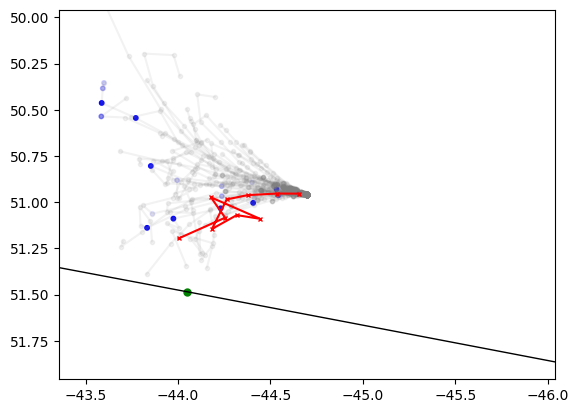

In [26]:
%matplotlib inline

zoom = 1
for i in range(config.n_samples):
    plt.plot(sample[i, :, 0], sample[i, :, 1], "o-", markersize=3, alpha=0.1, color="gray")
    plt.scatter(
        sample[i, :, 0], sample[i, :, 1], s=10, color="blue", marker="o", alpha=cost_sample[i, :]
    )
plt.plot(opt_sample[:, 0], opt_sample[:, 1], "x-", markersize=3, color="red")
plt.plot(ref_sample[:, 0], ref_sample[:, 1], "o", markersize=5, color="green")
plt.plot(mppi.waypoints[:, 1], mppi.waypoints[:, 2], "k-", markersize=3, linewidth=1)
plt.axis("equal")
plt.xlim(sample[0, 0, 0] + zoom, sample[0, 0, 0] - zoom)
plt.ylim(sample[0, 0, 1] + zoom, sample[0, 0, 1] - zoom)

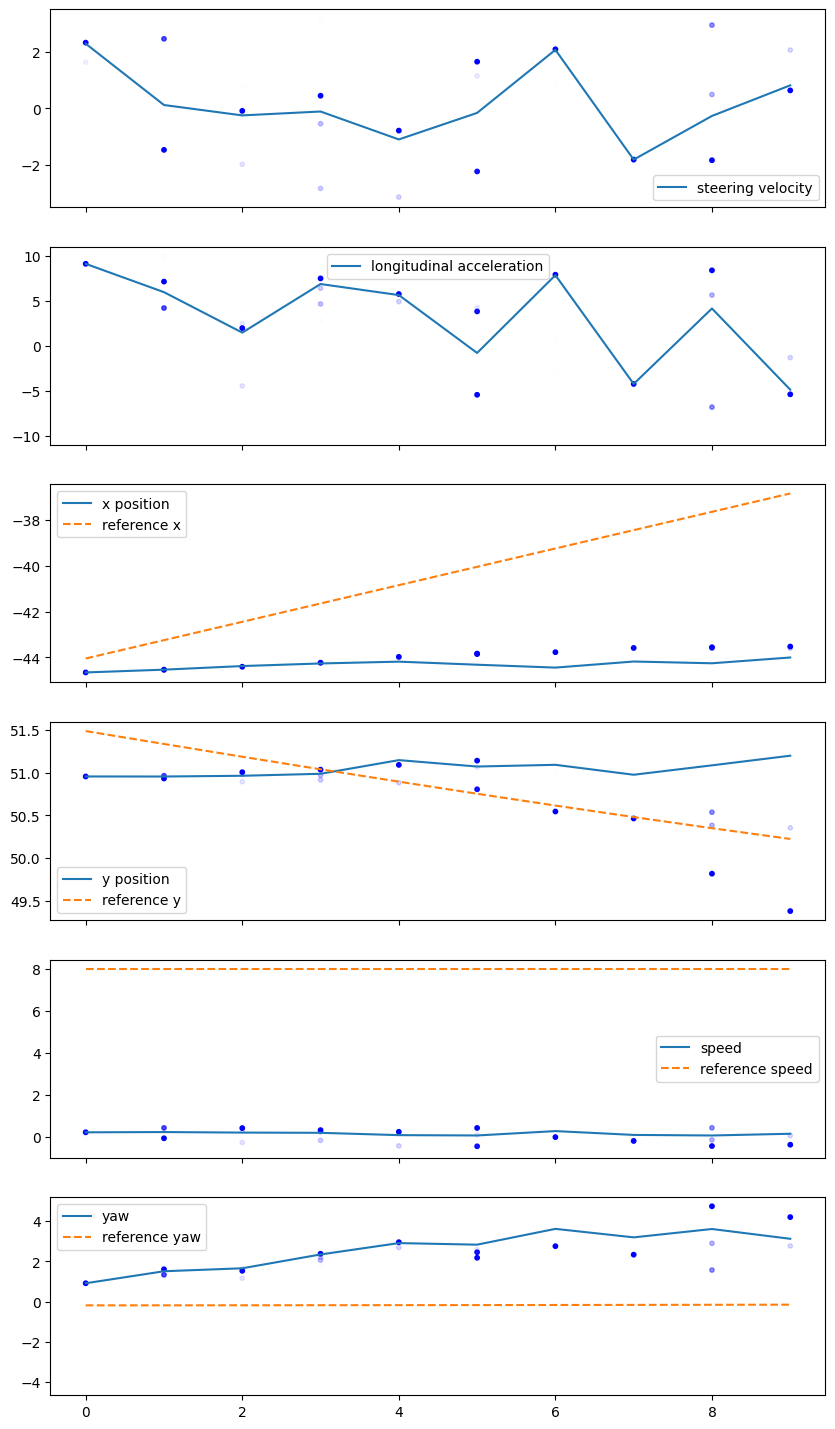

In [24]:
# subplot figure, share x
fig, ax = plt.subplots(6, 1, sharex=True, figsize=(10, 18))
ax[0].plot(opt_a_sample[:, 0], label="steering velocity")
ax[0].legend()
ax[1].plot(opt_a_sample[:, 1], label="longitudinal acceleration")
ax[1].legend()
ax[2].plot(opt_sample[:, 0], label="x position")
ax[2].plot(ref_sample[:, 0], label="reference x", linestyle='--')
ax[2].legend()
ax[3].plot(opt_sample[:, 1], label="y position")
ax[3].plot(ref_sample[:, 1], label="reference y", linestyle='--')
ax[3].legend()
ax[4].plot(opt_sample[:, 2], label="speed")
ax[4].plot(ref_sample[:, 2], label="reference speed", linestyle='--')
ax[4].legend()
ax[5].plot(opt_sample[:, 3], label="yaw")
ax[5].plot(ref_sample[:, 3], label="reference yaw", linestyle='--')
ax[5].legend()
for i in range(config.n_samples):
    ax[0].scatter(
        jnp.arange(config.n_steps), a_sample[i, :, 0], s=10, color="blue", marker="o", alpha=cost_sample[i, :]
    )
    ax[1].scatter(
        jnp.arange(config.n_steps), a_sample[i, :, 1], s=10, color="blue", marker="o", alpha=cost_sample[i, :]
    )
    ax[2].scatter(
        jnp.arange(config.n_steps), sample[i, :, 0], s=10, color="blue", marker="o", alpha=cost_sample[i, :]
    )
    ax[3].scatter(
        jnp.arange(config.n_steps), sample[i, :, 1], s=10, color="blue", marker="o", alpha=cost_sample[i, :]
    )
    ax[4].scatter(
        jnp.arange(config.n_steps), sample[i, :, 2], s=10, color="blue", marker="o", alpha=cost_sample[i, :]
    )
    ax[5].scatter(
        jnp.arange(config.n_steps), sample[i, :, 3], s=10, color="blue", marker="o", alpha=cost_sample[i, :]
    )

In [ ]:
player = TrajRenderer(env)
player.render(np.array(all_runner_state[0].cartesian_states))